In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm

from training_utils import HumanPoseDataset, Config

def get_transforms(config, train=True):
    size = transforms.Resize(config.img_size)
    to_tensor = transforms.ToTensor()
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    if train:
        aug = transforms.Compose([
            size,
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=10),
            transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
            transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05),
            to_tensor,
            normalize,
            transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.5))], p=0.5),
            transforms.RandomErasing(p=0.25, scale=(0.02, 0.1), ratio=(0.3, 3.3))
        ])
    else:
        aug = transforms.Compose([
            size,
            to_tensor,
            normalize
        ])

    return aug

def load_data(config):
    print("\n[1/4] Загрузка данных...")
    train_df = pd.read_csv(config.train_answers_file)
    print(f"Пример данных:\n{train_df.head()}")

    print("\n[2/4] Валидация данных...")
    train_df = train_df.dropna()
    print(f"Данных после очистки: {len(train_df)}")

    print("\n[3/4] Проверка изображений...")
    existing_images = {f.split('.')[0] for f in os.listdir(config.img_train_dir)}
    print(f"Найдено изображений: {len(existing_images)}")

    train_df = train_df[train_df['img_id'].astype(str).isin(existing_images)]
    print(f"Данных после фильтрации: {len(train_df)}")

    print("\n[4/4] Разделение данных...")
    train_df, test_val_df = train_test_split(
        train_df,
        test_size=config.test_size + config.val_size,
        stratify=train_df['target_feature'],
        random_state=config.random_state
    )
    val_df, test_df = train_test_split(
        test_val_df,
        test_size=config.test_size / (config.test_size + config.val_size),
        stratify=test_val_df['target_feature'],
        random_state=config.random_state
    )

    return (
        HumanPoseDataset(train_df, config.img_train_dir, get_transforms(config, True)),
        HumanPoseDataset(val_df, config.img_train_dir, get_transforms(config, False)),
        HumanPoseDataset(test_df, config.img_train_dir, get_transforms(config, False))
    )

In [3]:
class MBConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, expand_ratio, stride):
        super().__init__()
        hidden_dim = in_channels * expand_ratio
        self.use_residual = (in_channels == out_channels and stride == 1)

        layers = []
        if expand_ratio != 1:
            layers.append(nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False))
            layers.append(nn.BatchNorm2d(hidden_dim))
            layers.append(nn.SiLU())

        layers.append(nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim, bias=False))
        layers.append(nn.BatchNorm2d(hidden_dim))
        layers.append(nn.SiLU())

        layers.append(nn.Conv2d(hidden_dim, out_channels, kernel_size=1, bias=False))
        layers.append(nn.BatchNorm2d(out_channels))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        out = self.block(x)
        if self.use_residual:
            return x + out
        return out


class CustomEfficientNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.SiLU()
        )

        self.blocks = nn.Sequential(
            MBConvBlock(32, 16, expand_ratio=1, stride=1),
            MBConvBlock(16, 24, expand_ratio=6, stride=2),
            MBConvBlock(24, 24, expand_ratio=6, stride=1),
            MBConvBlock(24, 40, expand_ratio=6, stride=2),
            MBConvBlock(40, 40, expand_ratio=6, stride=1),
            MBConvBlock(40, 80, expand_ratio=6, stride=2),
            MBConvBlock(80, 80, expand_ratio=6, stride=1),
            MBConvBlock(80, 112, expand_ratio=6, stride=1),
            MBConvBlock(112, 112, expand_ratio=6, stride=1),
            MBConvBlock(112, 192, expand_ratio=6, stride=2),
            MBConvBlock(192, 192, expand_ratio=6, stride=1),
            MBConvBlock(192, 320, expand_ratio=6, stride=1)
        )

        self.head = nn.Sequential(
            nn.Conv2d(320, 1280, kernel_size=1, bias=False),
            nn.BatchNorm2d(1280),
            nn.SiLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(1280, config.num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.blocks(x)
        return self.head(x)


class PoseTrainer:
    def __init__(self, config, device):
        self.config = config
        self.device = device
        self.best_metric = 0
        self.early_stop_counter = 0
        self.train_set, self.val_set, self.test_set = load_data(config)

        self.train_loader = DataLoader(
            self.train_set,
            batch_size=config.batch_size,
            shuffle=True,
            num_workers=6,
            pin_memory=True,
            prefetch_factor=4,
            persistent_workers=True
        )
        self.val_loader = DataLoader(
            self.val_set,
            batch_size=config.batch_size,
            num_workers=6,
            pin_memory=True,
            prefetch_factor=4,
            persistent_workers=True
        )
        self.test_loader = DataLoader(
            self.test_set,
            batch_size=config.batch_size,
            num_workers=6,
            pin_memory=True,
            prefetch_factor=4,
            persistent_workers=True
        )

        self.model = CustomEfficientNet(config).to(device)
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=config.epochs)
        self.criterion = nn.CrossEntropyLoss()
        self.scaler = torch.cuda.amp.GradScaler(enabled=device.type != 'cpu')

    def train(self):
        os.makedirs(self.config.save_dir, exist_ok=True)
        history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}

        for epoch in range(self.config.epochs):
            self.model.train()
            total_loss = 0
            all_preds, all_labels = [], []

            for images, labels in tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{self.config.epochs}"):
                images, labels = images.to(self.device, non_blocking=True), labels.to(self.device, non_blocking=True)
                self.optimizer.zero_grad()
                with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
                    outputs = self.model(images)
                    loss = self.criterion(outputs, labels)
                self.scaler.scale(loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()

                total_loss += loss.item()
                preds = torch.argmax(outputs, dim=1).detach().cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.detach().cpu().numpy())

            val_metrics = self.evaluate(self.val_loader)
            self.scheduler.step()

            history['train_loss'].append(total_loss / len(self.train_loader))
            history['val_loss'].append(val_metrics['loss'])
            history['val_acc'].append(val_metrics['accuracy'])
            history['val_f1'].append(val_metrics['f1'])

            print(f"Val F1: {val_metrics['f1']:.4f} | Val Acc: {val_metrics['accuracy']:.4f}")

            if val_metrics['f1'] > self.best_metric:
                self.best_metric = val_metrics['f1']
                self.early_stop_counter = 0
                torch.save(self.model.state_dict(), os.path.join(self.config.save_dir, 'best_model.pth'))
            else:
                self.early_stop_counter += 1
                if self.early_stop_counter >= self.config.early_stop_patience:
                    print(f"Early stopping at epoch {epoch+1} due to no F1 improvement.")
                    break

        self.plot_training(history)

    def evaluate(self, loader):
        self.model.eval()
        total_loss = 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(self.device, non_blocking=True), labels.to(self.device, non_blocking=True)
                with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
                    outputs = self.model(images)
                    loss = self.criterion(outputs, labels)
                total_loss += loss.item()
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.cpu().numpy())

        return {
            'loss': total_loss / len(loader),
            'accuracy': np.mean(np.array(all_preds) == np.array(all_labels)),
            'f1': f1_score(all_labels, all_preds, average='weighted')
        }

    def plot_training(self, history):
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.plot(history['train_loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Val Loss')
        plt.legend()
        plt.title('Loss')

        plt.subplot(1, 3, 2)
        plt.plot(history['val_acc'], label='Val Acc')
        plt.legend()
        plt.title('Accuracy')

        plt.subplot(1, 3, 3)
        plt.plot(history['val_f1'], label='Val F1')
        plt.legend()
        plt.title('F1 Score')

        plt.tight_layout()
        plt.savefig(os.path.join(self.config.save_dir, 'training_metrics.png'))
        plt.show()

4

[1/4] Загрузка данных...
Пример данных:
   img_id  target_feature
0   17363               2
1    8612               5
2    8244               0
3    9264               0
4    5382               6

[2/4] Валидация данных...
Данных после очистки: 12367

[3/4] Проверка изображений...
Найдено изображений: 12367
Данных после фильтрации: 12367

[4/4] Разделение данных...


/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:107: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=device.type != 'cpu')
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Layer (type:depth-idx)                   Output Shape              Param #
CustomEfficientNet                       [16, 16]                  --
├─Sequential: 1-1                        [16, 32, 250, 250]        --
│    └─Conv2d: 2-1                       [16, 32, 250, 250]        864
│    └─BatchNorm2d: 2-2                  [16, 32, 250, 250]        64
│    └─SiLU: 2-3                         [16, 32, 250, 250]        --
├─Sequential: 1-2                        [16, 320, 16, 16]         --
│    └─MBConvBlock: 2-4                  [16, 16, 250, 250]        --
│    │    └─Sequential: 3-1              [16, 16, 250, 250]        896
│    └─MBConvBlock: 2-5                  [16, 24, 125, 125]        --
│    │    └─Sequential: 3-2              [16, 24, 125, 125]        5,136
│    └─MBConvBlock: 2-6                  [16, 24, 125, 125]        --
│    │    └─Sequential: 3-3              [16, 24, 125, 125]        8,832
│    └─MBConvBlock: 2-7                  [16, 40, 63, 63]          --
│    │ 

Epoch 1/50:   0%|                                                                                    | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 1/50: 100%|██████████████████████████████████████████████████████████████████████████| 541/541 [01:33<00:00,  5.81it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.2059 | Val Acc: 0.2631


Epoch 2/50:   0%|                                                                                    | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 2/50: 100%|██████████████████████████████████████████████████████████████████████████| 541/541 [01:22<00:00,  6.52it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.2179 | Val Acc: 0.2825


Epoch 3/50:   0%|                                                                                    | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 3/50: 100%|██████████████████████████████████████████████████████████████████████████| 541/541 [01:36<00:00,  5.61it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.2251 | Val Acc: 0.2911


Epoch 4/50:   0%|                                                                                    | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 4/50: 100%|██████████████████████████████████████████████████████████████████████████| 541/541 [01:49<00:00,  4.95it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.2436 | Val Acc: 0.3089


Epoch 5/50:   0%|                                                                                    | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 5/50: 100%|██████████████████████████████████████████████████████████████████████████| 541/541 [01:38<00:00,  5.50it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.2846 | Val Acc: 0.3472


Epoch 6/50:   0%|                                                                                    | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 6/50: 100%|██████████████████████████████████████████████████████████████████████████| 541/541 [01:34<00:00,  5.72it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.2514 | Val Acc: 0.3191


Epoch 7/50:   0%|                                                                                    | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 7/50: 100%|██████████████████████████████████████████████████████████████████████████| 541/541 [01:33<00:00,  5.79it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.3011 | Val Acc: 0.3558


Epoch 8/50:   0%|                                                                                    | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 8/50: 100%|██████████████████████████████████████████████████████████████████████████| 541/541 [01:33<00:00,  5.81it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.2909 | Val Acc: 0.3601


Epoch 9/50:   0%|                                                                                    | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 9/50: 100%|██████████████████████████████████████████████████████████████████████████| 541/541 [01:33<00:00,  5.78it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.3305 | Val Acc: 0.3795


Epoch 10/50:   0%|                                                                                   | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 10/50: 100%|█████████████████████████████████████████████████████████████████████████| 541/541 [14:28<00:00,  1.61s/it]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.3132 | Val Acc: 0.3590


Epoch 11/50:   0%|                                                                                   | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 11/50: 100%|█████████████████████████████████████████████████████████████████████████| 541/541 [01:28<00:00,  6.08it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.3424 | Val Acc: 0.3914


Epoch 12/50:   0%|                                                                                   | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 12/50: 100%|█████████████████████████████████████████████████████████████████████████| 541/541 [01:21<00:00,  6.61it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.3410 | Val Acc: 0.3822


Epoch 13/50:   0%|                                                                                   | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 13/50: 100%|█████████████████████████████████████████████████████████████████████████| 541/541 [01:24<00:00,  6.41it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.3336 | Val Acc: 0.3903


Epoch 14/50:   0%|                                                                                   | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 14/50: 100%|█████████████████████████████████████████████████████████████████████████| 541/541 [01:35<00:00,  5.67it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.3480 | Val Acc: 0.3957


Epoch 15/50:   0%|                                                                                   | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 15/50: 100%|█████████████████████████████████████████████████████████████████████████| 541/541 [01:41<00:00,  5.32it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.3474 | Val Acc: 0.4011


Epoch 16/50:   0%|                                                                                   | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 16/50: 100%|█████████████████████████████████████████████████████████████████████████| 541/541 [01:34<00:00,  5.72it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.3633 | Val Acc: 0.4113


Epoch 17/50:   0%|                                                                                   | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 17/50: 100%|█████████████████████████████████████████████████████████████████████████| 541/541 [01:31<00:00,  5.92it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.3504 | Val Acc: 0.4054


Epoch 18/50:   0%|                                                                                   | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 18/50: 100%|█████████████████████████████████████████████████████████████████████████| 541/541 [01:30<00:00,  5.99it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.3664 | Val Acc: 0.4097


Epoch 19/50:   0%|                                                                                   | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 19/50: 100%|█████████████████████████████████████████████████████████████████████████| 541/541 [01:30<00:00,  5.97it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.3768 | Val Acc: 0.4221


Epoch 20/50:   0%|                                                                                   | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 20/50: 100%|█████████████████████████████████████████████████████████████████████████| 541/541 [01:31<00:00,  5.90it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.3718 | Val Acc: 0.4253


Epoch 21/50:   0%|                                                                                   | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 21/50: 100%|█████████████████████████████████████████████████████████████████████████| 541/541 [01:31<00:00,  5.92it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.3908 | Val Acc: 0.4388


Epoch 22/50:   0%|                                                                                   | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 22/50: 100%|█████████████████████████████████████████████████████████████████████████| 541/541 [01:33<00:00,  5.77it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.3987 | Val Acc: 0.4377


Epoch 23/50:   0%|                                                                                   | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 23/50: 100%|█████████████████████████████████████████████████████████████████████████| 541/541 [01:37<00:00,  5.53it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4047 | Val Acc: 0.4415


Epoch 24/50:   0%|                                                                                   | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 24/50: 100%|█████████████████████████████████████████████████████████████████████████| 541/541 [01:39<00:00,  5.44it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4200 | Val Acc: 0.4652


Epoch 25/50:   0%|                                                                                   | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 25/50: 100%|█████████████████████████████████████████████████████████████████████████| 541/541 [01:37<00:00,  5.53it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4103 | Val Acc: 0.4534


Epoch 26/50:   0%|                                                                                   | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 26/50: 100%|█████████████████████████████████████████████████████████████████████████| 541/541 [16:54<00:00,  1.87s/it]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4197 | Val Acc: 0.4620


Epoch 27/50:   0%|                                                                                   | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 27/50: 100%|█████████████████████████████████████████████████████████████████████████| 541/541 [01:20<00:00,  6.68it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4075 | Val Acc: 0.4491


Epoch 28/50:   0%|                                                                                   | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 28/50: 100%|█████████████████████████████████████████████████████████████████████████| 541/541 [01:23<00:00,  6.50it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4395 | Val Acc: 0.4792


Epoch 29/50:   0%|                                                                                   | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 29/50: 100%|█████████████████████████████████████████████████████████████████████████| 541/541 [01:38<00:00,  5.48it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4333 | Val Acc: 0.4739


Epoch 30/50:   0%|                                                                                   | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 30/50: 100%|█████████████████████████████████████████████████████████████████████████| 541/541 [02:13<00:00,  4.06it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4399 | Val Acc: 0.4782


Epoch 31/50:   0%|                                                                                   | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 31/50: 100%|█████████████████████████████████████████████████████████████████████████| 541/541 [01:58<00:00,  4.57it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4589 | Val Acc: 0.4960


Epoch 32/50:   0%|                                                                                   | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 32/50: 100%|█████████████████████████████████████████████████████████████████████████| 541/541 [05:32<00:00,  1.63it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4475 | Val Acc: 0.4900


Epoch 33/50:   0%|                                                                                   | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 33/50: 100%|█████████████████████████████████████████████████████████████████████████| 541/541 [01:51<00:00,  4.86it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4587 | Val Acc: 0.5024


Epoch 34/50:   0%|                                                                                   | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 34/50: 100%|█████████████████████████████████████████████████████████████████████████| 541/541 [01:51<00:00,  4.84it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4751 | Val Acc: 0.5132


Epoch 35/50:   0%|                                                                                   | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 35/50: 100%|█████████████████████████████████████████████████████████████████████████| 541/541 [01:52<00:00,  4.83it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4630 | Val Acc: 0.4987


Epoch 36/50:   0%|                                                                                   | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 36/50: 100%|█████████████████████████████████████████████████████████████████████████| 541/541 [01:56<00:00,  4.64it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4689 | Val Acc: 0.5062


Epoch 37/50:   0%|                                                                                   | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 37/50: 100%|█████████████████████████████████████████████████████████████████████████| 541/541 [01:56<00:00,  4.65it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4692 | Val Acc: 0.5100


Epoch 38/50:   0%|                                                                                   | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 38/50: 100%|█████████████████████████████████████████████████████████████████████████| 541/541 [01:56<00:00,  4.65it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4736 | Val Acc: 0.5100


Epoch 39/50:   0%|                                                                                   | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 39/50: 100%|█████████████████████████████████████████████████████████████████████████| 541/541 [01:56<00:00,  4.65it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4778 | Val Acc: 0.5121


Epoch 40/50:   0%|                                                                                   | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 40/50: 100%|█████████████████████████████████████████████████████████████████████████| 541/541 [01:56<00:00,  4.65it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4768 | Val Acc: 0.5127


Epoch 41/50:   0%|                                                                                   | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 41/50: 100%|█████████████████████████████████████████████████████████████████████████| 541/541 [01:56<00:00,  4.65it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4776 | Val Acc: 0.5170


Epoch 42/50:   0%|                                                                                   | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 42/50: 100%|█████████████████████████████████████████████████████████████████████████| 541/541 [01:56<00:00,  4.65it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4797 | Val Acc: 0.5170


Epoch 43/50:   0%|                                                                                   | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 43/50: 100%|█████████████████████████████████████████████████████████████████████████| 541/541 [01:53<00:00,  4.78it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4816 | Val Acc: 0.5202


Epoch 44/50:   0%|                                                                                   | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 44/50: 100%|█████████████████████████████████████████████████████████████████████████| 541/541 [01:53<00:00,  4.78it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4876 | Val Acc: 0.5267


Epoch 45/50:   0%|                                                                                   | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 45/50: 100%|█████████████████████████████████████████████████████████████████████████| 541/541 [01:52<00:00,  4.81it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4852 | Val Acc: 0.5256


Epoch 46/50:   0%|                                                                                   | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 46/50: 100%|█████████████████████████████████████████████████████████████████████████| 541/541 [01:51<00:00,  4.85it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4849 | Val Acc: 0.5213


Epoch 47/50:   0%|                                                                                   | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 47/50: 100%|█████████████████████████████████████████████████████████████████████████| 541/541 [01:49<00:00,  4.92it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4841 | Val Acc: 0.5245


Epoch 48/50:   0%|                                                                                   | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 48/50: 100%|█████████████████████████████████████████████████████████████████████████| 541/541 [01:50<00:00,  4.91it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4906 | Val Acc: 0.5278


Epoch 49/50:   0%|                                                                                   | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 49/50: 100%|█████████████████████████████████████████████████████████████████████████| 541/541 [01:51<00:00,  4.87it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4808 | Val Acc: 0.5186


Epoch 50/50:   0%|                                                                                   | 0/541 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 50/50: 100%|█████████████████████████████████████████████████████████████████████████| 541/541 [01:47<00:00,  5.04it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/463813912.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4878 | Val Acc: 0.5256


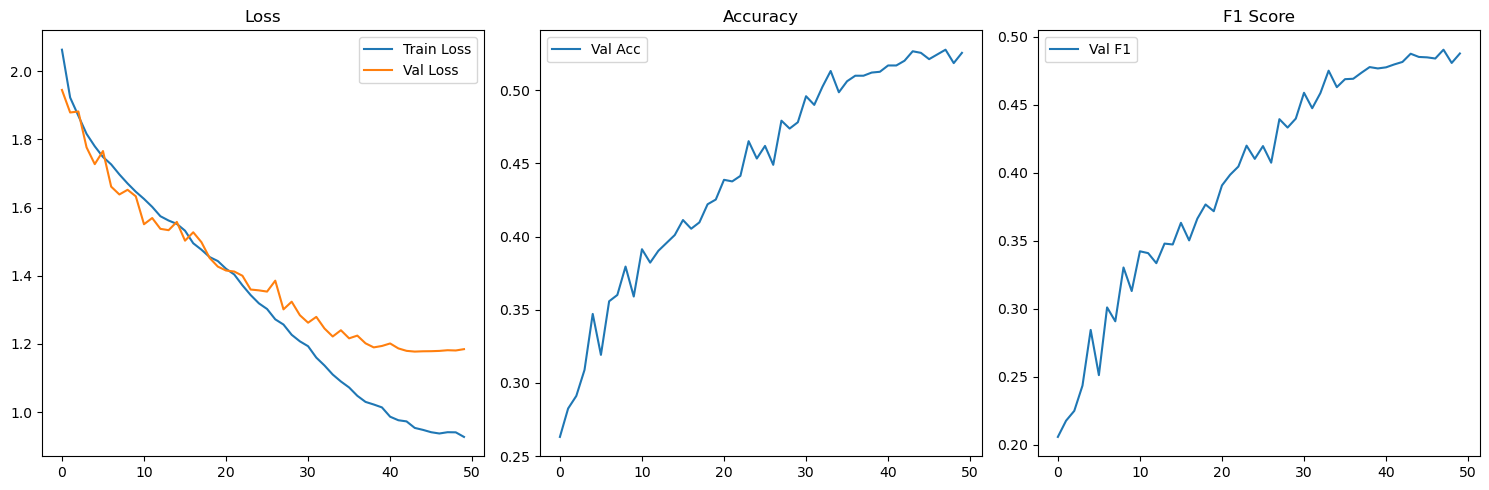

In [6]:
def main():
    device = torch.device('mps')
    config = Config()
    print(config.num_workers)
    trainer = PoseTrainer(config, device)

    # Модельный summary
    from torchinfo import summary
    print(summary(trainer.model, input_size=(config.batch_size, 3, *config.img_size), device=device.type))

    trainer.train()


if __name__ == '__main__':
    main()

In [8]:
import torch
import pandas as pd
import os
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class TestPoseDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id = str(self.df.iloc[idx]['img_id']).strip()
        img_path = os.path.join(self.img_dir, f"{img_id}.jpg")

        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"[WARN] Failed to open {img_path}: {e}")
            image = Image.new('RGB', Config.img_size)

        if self.transform:
            image = self.transform(image)

        return image, img_id


def get_test_transform(config):
    return transforms.Compose([
        transforms.Resize(config.img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


def predict():
    config = Config()
    device = torch.device('mps')

    test_img_dir = os.path.join(config.data_root, 'img_test')
    test_img_names = sorted(
        (f for f in os.listdir(test_img_dir) if f.endswith('.jpg')),
        key=lambda x: int(os.path.splitext(x)[0])
    )
    df = pd.DataFrame({'img_id': [os.path.splitext(f)[0] for f in test_img_names]})
    test_dataset = TestPoseDataset(df, test_img_dir, transform=get_test_transform(config))
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=0)

    model = CustomEfficientNet(config).to(device)
    model.load_state_dict(torch.load(os.path.join(config.save_dir, 'best_model.pth'), map_location=device))
    model.eval()

    results = []
    with torch.no_grad():
        for images, img_ids in test_loader:
            images = images.to(device, non_blocking=True)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            results.extend(zip(img_ids, preds))

    output_df = pd.DataFrame(results, columns=['id', 'target_feature'])
    output_csv_path = os.path.join(config.save_dir, 'test_predictions.csv')
    output_df.to_csv(output_csv_path, index=False)
    print(f"Predictions saved to {output_csv_path}")


if __name__ == '__main__':
    predict()

/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_21440/864233166.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join

Predictions saved to saved_models_efficientnet/test_predictions.csv
